# 1. Confined Aquifer Test - Oude Korendijk

### Import packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timflow.transient as tft

plt.rcParams["figure.figsize"] = (5, 3)  # default figure size

### Introduction and Conceptual Model

In this example, we will use the pumping test data from Oude Korendijk (Kruseman et al. 1970). 

Oude Korendijk is a polder area South of Rotterdam, the Netherlands. The stratigraphy can be summarized by:
* the first 18 m consist of almost impermeable material,
* the next 7 m is succession of coarse gravel and sands, which are considered as the aquifer layer,
* a layer of fine sands and clayey sediments that are deemed impermeable.

The well screens the whole thickness of the confined aquifer. Drawdowns were measured in two piezometers located at distances of 30 m and 90 m from the well. The pumping well discharge was constant at 788 m$^3$/d for almost 14 hours. The objective of the pumping test was to estimate the hydraulic conductivity and the specific storage of the aquifer layer. 

<img src="./figs/oude_korendijk.png" style="width:400pt">

### Load data

In [9]:
# time and drawdown of piezometer 30m away from pumping well
data1 = np.loadtxt("data/piezometer_h30.txt", skiprows=1)
to1 = data1[:, 0] / 60 / 24  # convert min to days
ho1 = data1[:, 1]
ro1 = 30
# time and drawdown of piezometer 90m away from pumping well
data2 = np.loadtxt("data/piezometer_h90.txt", skiprows=1)
to2 = data2[:, 0] / 60 / 24  # convert min to days
ho2 = data2[:, 1]
ro2 = 90

### Parameters and model

In [12]:
# known parameters
H = 7  # aquifer thickness in meters, m
zt = -18  # top boundary of aquifer, m
zb = zt - H  # bottom boundary of aquifer, m
Q = 788  # constant discharge, m3/d

In [16]:
# timflow model
ml = tft.ModelMaq(kaq=60, z=[zt, zb], Saq=1e-4, tmin=1e-5, tmax=1)
w = tft.Well(model=ml, xw=0, yw=0, rw=0.2, tsandQ=[(0, Q)], layers=0)
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters
The aquifer parameters are estimated using head observations at both piezometers.

In [19]:
# unknown parameters: kaq, Saq
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", initial=10, layers=0)
cal.set_parameter(name="Saq", initial=1e-4, layers=0)
cal.series(name="obs1", x=ro1, y=0, t=to1, h=ho1, layer=0)  # Adding well 1
cal.series(name="obs2", x=ro2, y=0, t=to2, h=ho2, layer=0)  # Adding well 2
cal.fit(report=True)

.................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 69
    # variables        = 2
    chi-square         = 0.17291363
    reduced chi-square = 0.00258080
    Akaike info crit   = -409.245801
    Bayesian info crit = -404.777588
[[Variables]]
    kaq_0_0:  66.0893536 +/- 1.65499500 (2.50%) (init = 10)
    Saq_0_0:  2.5409e-05 +/- 2.4016e-06 (9.45%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_0, Saq_0_0) = -0.8553


In [21]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,66.089354,1.654995,2.504178,-inf,inf,10.0000,None,[[66.08935356677974]]
Saq_0_0,0,0.000025,0.000002,9.451954,-inf,inf,0.0001,None,[[2.5408597145414816e-05]]


RMSE: 0.05005991006296439


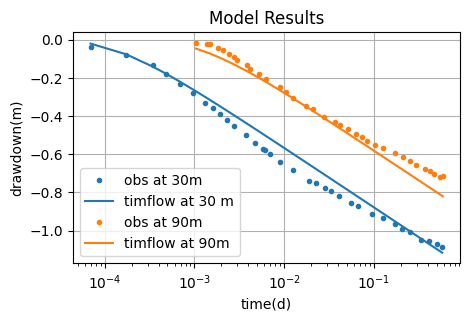

In [26]:
hm1 = ml.head(ro1, 0, to1)
hm2 = ml.head(ro2, 0, to2)
plt.semilogx(to1, ho1, "C0.", label="obs at 30m")
plt.semilogx(to1, hm1[0], "C0", label="timflow at 30 m")
plt.semilogx(to2, ho2, "C1.", label="obs at 90m")
plt.semilogx(to2, hm2[0], "C1", label="timflow at 90m")
plt.title("Model Results")
plt.xlabel("time(d)")
plt.ylabel("drawdown(m)")
plt.legend()
plt.grid()

### Comparison of results

The performance of `timflow` was evaluated by comparison with AQTESOLV (Duffield, 2007), MLU (Carlson and Randall, 2012), and Kruseman and de Ridder (1970), here abbreviated to K&dR. Results from `timflow` and AQTESOLV are identical, those from MLU are very similar, while the solution of Kruseman and de Ridder shows small deviations.

In [28]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"], 
    index=["timflow", "AQTESOLV", "MLU", "K&dR"]
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["AQTESOLV"] = [66.086, 2.541e-05, 0.05006]
t.loc["MLU"] = [66.850, 2.400e-05, 0.05083]
t.loc["K&dR"] = [55.71429, 1.7e-4, "-" ]

t_formatted = t.style.format({"k [m/d]": "{:.2f}", 
                              "Ss [1/m]": "{:.2e}",  
                              "RMSE [m]": lambda x: "-" if x == "-" else f"{float(x):.3f}"})
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,66.09,2.54e-05,0.050
AQTESOLV,66.09,2.54e-05,0.050
MLU,66.85,2.40e-05,0.051
K&dR,55.71,1.70e-04,-


## References

* Bakker, M. (2013), Semi-analytic modeling of transient multi-layer flow with TTim, Hydrogeol J 21, 935–943, https://doi.org/10.1007/s10040-013-0975-2
* Carlson, F. and Randall, J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Kruseman, G.P., De Ridder, N.A. and Verweij, J.M. (1970), Analysis and evaluationof pumping test data, volume 11, International institute for land reclamation and improvement The Netherlands.